In [1]:
from google.colab import drive

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import numpy as np

import copy
import json

In [2]:
# Hyperparameters

BATCH_SIZE = 32
BLOCK_SIZE = 4
N_CENTROIDS = 50
DELTA = abs(2.170973157686992 - 0.003227713898589287) / 2
MODULE_FILTER = lambda name, module: isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) and name != 'classifier.6'

In [3]:
# Model setup

drive.mount('/content/gdrive')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_data = datasets.CIFAR10('cifar10', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device('cuda')

model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load('/content/gdrive/My Drive/vgg16legos.pt'))
model = model.to(device)
torch.set_grad_enabled(False)


def test(model):
    model.eval()
    correct = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        predictions = output.argmax(1)
        correct += (predictions == y).sum().item()
    return correct / len(test_loader.dataset)

print(f'Baseline accuracy: {test(model)}')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Files already downloaded and verified
Baseline accuracy: 0.9002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Expected label: dog
Predicted label: cat


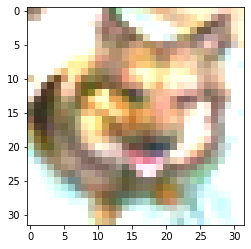

In [4]:
# Sample image
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
output = model(x)
predictions = torch.argmax(F.log_softmax(output, dim=1).cpu(), axis=1)
plt.imshow(x[0].permute(1, 2, 0).cpu())
print(f'Expected label: {classes[y[0]]}')
print(f'Predicted label: {classes[predictions[0]]}')

In [5]:
def blockify(x, block_width, block_height):
    return x.reshape(-1, block_width * block_height)


def deblockify(x, *original_dimensions):
    return x.reshape(*original_dimensions)


def legoifier(model, block_size=BLOCK_SIZE, n_centroids=N_CENTROIDS, module_filter=MODULE_FILTER):
    modules_to_update = [
        module for name, module in model.named_modules()
        if module_filter(name, module)
    ]

    # Group into blocks

    blocks = torch.cat([
        blockify(module.weight, block_size, block_size)
        for module in modules_to_update
    ])

    # Cluster blocks

    kmeans = MiniBatchKMeans(
        n_clusters=n_centroids,
        init='k-means++',
        random_state=0
    )
    distances = kmeans.fit_transform(blocks.cpu())
    distances = distances[np.arange(distances.shape[0]), kmeans.labels_]
    distances = torch.from_numpy(distances).to(device)

    def legoify(delta=DELTA):
        lego_model = copy.deepcopy(model)
        modules_to_update = [
            module for name, module in lego_model.named_modules()
            if module_filter(name, module)
        ]
        blocks = torch.cat([
            blockify(module.weight, block_size, block_size)
            for module in modules_to_update
        ])

        # Replace blocks closest to centers with those centers

        legos = torch.where(
            (distances < delta).view(-1, 1),
            torch.from_numpy(kmeans.cluster_centers_[kmeans.labels_]).to(device).type_as(blocks),
            blocks
        )
        blocks_replaced = (blocks != legos).all(axis=1).sum()
        block_count = len(legos)

        # Convert legos back to original shape and update model

        legos_used = 0

        for i, module in enumerate(modules_to_update):
            n_legos = module.weight.numel() // block_size ** 2
            module_legos = legos[legos_used:legos_used + n_legos]
            legos_used += n_legos
            updated_weight = deblockify(module_legos, *module.weight.shape)
            module.weight.data = torch.as_tensor(updated_weight).to(device)
        
        return lego_model, blocks_replaced, block_count
    
    return legoify

In [6]:
module_filters = {
    'all': MODULE_FILTER,
    'conv': lambda name, module: isinstance(module, nn.Conv2d),
    'linear': lambda name, module: isinstance(module, nn.Linear) and name != 'classifier.6'
}
deltas = np.linspace(0.001, 0.1, num=50)

results = {}
for filter_name, module_filter in module_filters.items():
    results[filter_name] = {}
    legoify = legoifier(model, module_filter=module_filter)
    for delta in deltas:
        lego_model, blocks_replaced, block_count = legoify(delta=delta)
        accuracy = test(lego_model)
        results[filter_name][delta] = {
            'accuracy': accuracy,
            'replaced': (blocks_replaced / block_count).item()
        }

del lego_model  # Takes up 0.5 GB of memory!

with open('/content/gdrive/My Drive/legos.json', 'w') as f:
    json.dump(results, f, sort_keys=True, indent=4)

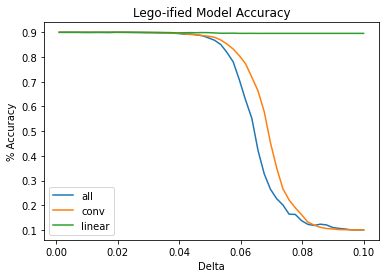

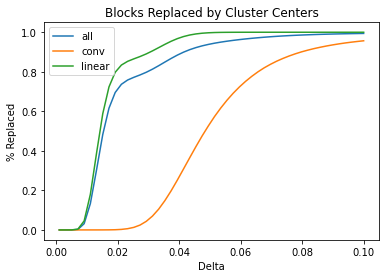

In [27]:
plt.title('Lego-ified Model Accuracy')
plt.xlabel('Delta')
plt.ylabel('% Accuracy')
for filter_name in module_filters.keys():
    plt.plot(list(results[filter_name].keys()), [value['accuracy'] for value in results[filter_name].values()], label=filter_name)
plt.legend()
plt.show()

plt.title('Blocks Replaced by Cluster Centers')
plt.xlabel('Delta')
plt.ylabel('% Replaced')
for filter_name in module_filters.keys():
    plt.plot(list(results[filter_name].keys()), [value['replaced'] for value in results[filter_name].values()], label=filter_name)
plt.legend()
plt.show()